# PROJECT VISUAL INSPECTION OF MOTORCYCLE CONNECTING RODS

Gianmarco Canello

Marco Roncato

Stefano Bortolotti

Stefano Mulargia


# TASKS: 

For each connecting rod appearing in the image, the vision system should provide the following information:  
 
1. Type of rod (type A = rod with 1 hole or type B = rod with 2 holes). 

2. Position and orientation (modulo pi). 

3. Length (L), Width (W), Width at the barycenter (WB).

4. For each hole, position of the center and diameter size.  
 

# LIBRARIES:

In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
from scipy.spatial import distance

%matplotlib inline 

print("The OpenCV version is:", cv2.__version__)

The OpenCV version is: 4.5.3


The following function "check_powder" returns a bool variable if the image binarized has many elements inside of it. This is sort of an heuristic evaluation since we notice that usually in a clean image the number of contours is small. The value that determines if there is powder in the image is that there are more than 10 contours.

We decide to implement this simple heuristic function instead of looking for the dimension of the area for computational reasons.

we chose the standard "cv2.threshold" method because we found it to be a good solution for binarizing our image.

In [2]:
def check_powder(img):
    _,image_b_ =cv2.threshold(img.astype(np.uint8),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    contours_, _ = cv2.findContours(image_b_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if len(contours_)>10:           # heuristic, number of object 
        powder_present  = True
    else:
        powder_present  = False

    return powder_present



# IMAGE IMPORTATION:

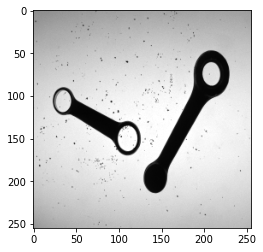

In [3]:
# images: 00 01 12 21 31 33 44 47 48 49 50 51 90 92 98
# 50 51 connected rods
# 90 92 98 connected rods
image_to_load = 'TESI98.BMP'

image = cv2.imread(image_to_load,cv2.IMREAD_GRAYSCALE) 

plt.imshow(image, cmap='gray', vmin=0, vmax=255);



# HISTOGRAM

We decide to use a *linear contrast stretching* in order to increase the constrast of the image, because some images are over/underexposed.

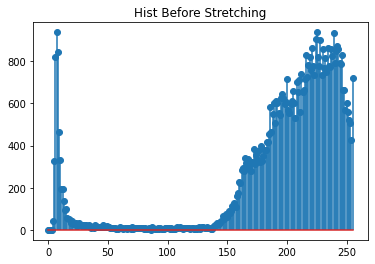

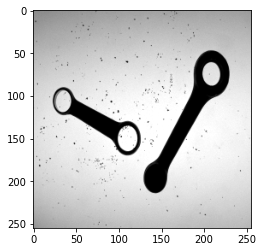

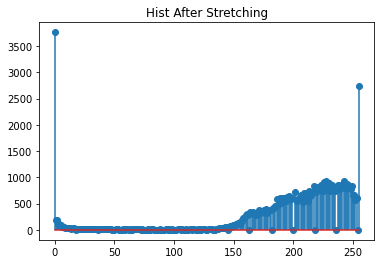

In [4]:
# Function and plotting taken from Lab session (credit)

def linear_stretching(img, max_value, min_value):
    img[img<min_value] = min_value
    img[img>max_value] = max_value
    linear_stretched_img = 255./(max_value-min_value)*(img-min_value)
    return linear_stretched_img


def find_percentile_value(hist, percentile):
    s = 0
    idx = 0
    total_pixel = np.sum(hist)
    while(s < total_pixel*percentile/100):
        s += hist[idx]
        idx += 1
    return idx


# Extracting the histogram
hist,bins = np.histogram(image.flatten(),256,[0,256])

# Plotting the histogram before stretching
plt.show()
plt.title("Hist Before Stretching")
plt.stem(hist, use_line_collection=True)
plt.show()


# Stretching with dynamic max and min based on percentiles.
max_value = find_percentile_value(hist, 95)
min_value = find_percentile_value(hist, 5)
# print("Max 95%: ", max_value, " Min 5%: ", min_value)
linear_stretched_img= linear_stretching(np.copy(image), max_value,min_value)
hist_st,bins = np.histogram(linear_stretched_img.astype(np.uint8).flatten(),256,[0,256])

image_s = linear_stretched_img


plt.imshow(linear_stretched_img,cmap='gray',vmin=0,vmax=255)
plt.savefig(f'out_linear_stretched_img_{image_to_load}.png')

plt.show()
plt.title("Hist After Stretching")
plt.stem(hist_st, use_line_collection=True)
plt.show()

# IMAGE FILTERING
The secong thing to do is to deal with noise.

We can deal with the scattered iron powder, as if it was an impulsive noise (salt and pepper noise), by emploing a median filter. 

We tried also to use a Gaussian filter to improve the overall result but we end up in finding out that spreading the image would cause a worsening in watershed algorithm later, by increasing the length of the touching border between objects, in this way the watershed algorithm could not separate some touching rods without separating involountarily a single rod. So we decided to do not implement it at all.

In general a single median filter is not able to remove completely the noise, to solve this we implemented another algorithm later that will also fill the other extraneous objects like screws and washers.


 Powder present in the image: True


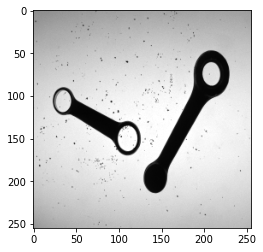

In [5]:
powder =  check_powder(image_s.astype(np.uint8))
image_f = image_s.astype(np.uint8)

if powder==True:
    image_f = cv2.medianBlur(image_f, 3)

print("\n Powder present in the image:",powder)

plt.imshow(image, cmap='gray', vmin=0, vmax=255);
plt.savefig(f'out_filtered_{image_to_load}.png')



# BINARIZATION:

In order to deal with different lighting levels we use a binary threshold with an Otsu algorithm. We found that the Otsu algorithm is the best to binarize the image in our application. Since it chosses the threshold level that will minimize the Within-group Variance.

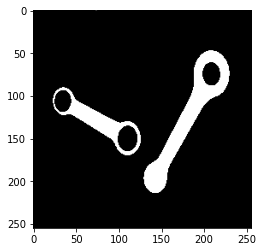

In [6]:
_,image_b = cv2.threshold(image_f.astype(np.uint8),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(image_b, cmap ='gray', vmin = 0, vmax = 255)
plt.savefig(f'out_binarized_{image_to_load}.png')


# Function barycenter

The following function consider two tipe of barycenter the one given by the contours (countours_func) and the one given by the area (centroids_func). The argument "cv2.RETR_TREE" retrieves all the contours and creates a full family hierarchy list. While "cv2.CHAIN_APPROX_NONE" defines the contour-approximation method, in this way we have a slower execution of the algorithm with respect to the other possible argument "CHAIN_APPROX_SIMPLE" but we detect all contours, because we need them to filter out every possible distraction from the image.

We computed a final Barycenter dictionary filled with the barycenter from the contours for the holes and from the area for the rods by computing the distance between the various contours, if this distance is the minimum value from all the other barycenters then the barycenters must be referred to the same object/hole so the dictionary can be updated without the repeating barycenters.


In [7]:
def Barycenter_computation(img_func,Barycenter_contours_func,Barycenter_func):
    ############## BLOB Barycenter ################
    [_, _, _, centroids_func] = cv2.connectedComponentsWithStats(img_func,connectivity=8)

    centroids_func = centroids_func.astype(int) # we convert as int joust for clarity
    ################################################

    ############# CONTOUR Barycenter ###############
    contours_func, hierarchy_func = cv2.findContours(img_func, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    for c in range(len(contours_func)):
        Barycenter_contours_func[c] = [int(sum(contours_func[c][:,0][:,0])/len(contours_func[c][:,0][:,0])), int(sum(contours_func[c][:,0][:,1])/len(contours_func[c][:,0][:,1]))]
    ################################################

    ################ UNIFICATION DICTIONARY ################# 

    for i in range(len(contours_func)):
        temp = 0                   
        dst_min = 10000             #just to set a value higher all the reasonable value i can get
        if hierarchy_func[0][i][3]==-1:             # if there are no parents
            for j in range(len(centroids_func)):
                dst = distance.euclidean(centroids_func[j], Barycenter_contours_func[i]) 
                if dst<dst_min:
                    dst_min = dst
                    temp = j
            Barycenter_func[i] = centroids_func[temp]  
        else:
            Barycenter_func[i] = Barycenter_contours_func[i]
    ################################################

    return contours_func, hierarchy_func ,Barycenter_func, Barycenter_contours_func 



In the following section we use the function previously defined.

In [8]:
Barycenter_contours_preproc = {}
Barycenter_preproc = {}
contours_preproc, hierarchy_preproc ,Barycenter_preproc, Barycenter_contours_preproc = Barycenter_computation(image_b,Barycenter_contours_preproc,Barycenter_preproc)


## In the following section we compute a dictionary with the contour of the powder that we will use later to remove completely the one remained after the median filter.

In order to do that we exploit the hierarchy of the object obtained with the funciton "findContours".

The first filters the objects with no hole that are outside the rods. (We count also the screws)

The second filters the contours of the powder inside the holes of the rods. (because we know that any object inside of the holes of the rods is a distraction)

In [9]:
Dict_contour_powder = {}

for i in range(len(contours_preproc)): 
    if (hierarchy_preproc[0][i][2] == -1) and (hierarchy_preproc[0][i][3] == -1): 
        Dict_contour_powder[i] = i # memorize the "name" (index)
    
    if (hierarchy_preproc[0][i][3] != -1) and (hierarchy_preproc[0][hierarchy_preproc[0][i][3]][3] != -1): 
        Dict_contour_powder[i] = i # memorize the "name" (index)


## In the following section of code we fill all the blobs that have no holes (screw and powder)

In [10]:
for i in Dict_contour_powder:
    image_b = cv2.fillConvexPoly(image_b,contours_preproc[Dict_contour_powder[i]], color=0)

## In the following section of code we fill the blobs (WASHERS) that are identified because the barycenter of both child and parent coincide (within 5 pixels as a margin of error).

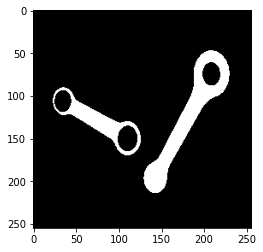

In [11]:
for key in range(0,len(Barycenter_preproc)-1):
    ####  Compute the euclidian distance between Child and Parent Barycenters
    barycenter = Barycenter_preproc[key]
    barycenter_next = Barycenter_preproc[key+1]
    dist_bar = distance.euclidean((barycenter[0],barycenter[1]), (barycenter_next[0],barycenter_next[1]))

    #### If they are close up to a arbitrary distance (chosen by us) fill the Washer. Ideally they shoul be the same but we prefer to stay safe due to possible pixel error.
    if dist_bar<5:
        image_b = cv2.fillConvexPoly(image_b,contours_preproc[key], color=0)


plt.imshow(image_b, cmap='gray', vmin=0, vmax=255)
plt.savefig(f'out_binarized_clean_{image_to_load}.png')

          

# WATERSHED 

We start our algorithm applying the Distance Transform operator that takes binary images as input.

The gray level intensities of the points inside the foreground regions are changed to distance from the closest zero value, to the boundary. This will help us in divide connected objects because it highlights the core of the rod and it shadows the touching points.

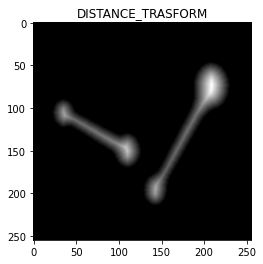

In [12]:
# Blob detection by watershed algorithm
# Copy the thresholded image.
image_floodfill = image_b.copy()

# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
row, column = image_b.shape[:2]
mask = np.zeros((row+2, column+2), np.uint8)

# Floodfill from point (0, 0), detects holes in the binarized image and fills them with white
cv2.floodFill(image_floodfill, mask, (0,0), 255);
# Invert floodfilled image
image_floodfill_inv = 255-image_floodfill

# Combine the two images to get the foreground.
image_combined = image_b | image_floodfill_inv

image_dist_transform = cv2.distanceTransform(image_combined,cv2.DIST_L2,5)
plt.imshow(image_dist_transform,'gray') 
plt.grid(False)
plt.title('DISTANCE_TRASFORM')
plt.show()


# # Extracting the histogram
# hist_image_dist_transform,_ = np.histogram(image_dist_transform.flatten(),256,[0,256])

# # Plotting the histogram before stretching
# plt.title("Hist Before Stretching")
# plt.stem(hist_image_dist_transform, use_line_collection=True)
# plt.show()

With nomalize the result to get a consistent thresholding across all images.

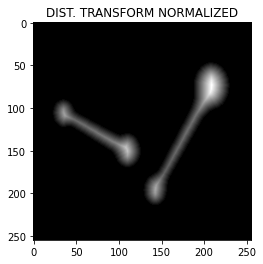

In [13]:
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv2.normalize(image_dist_transform, image_dist_transform, 0.0, 1.0, cv2.NORM_MINMAX)
#Threshold to obtain the peaks

plt.imshow(image_dist_transform,'gray') 
plt.grid(False)
plt.title('DIST. TRANSFORM NORMALIZED')
plt.savefig(f'out_distance_transform_normalized_{image_to_load}.png')

plt.show()


# # Extracting the histogram
# # hist_image_dist_transform,_ = np.histogram(image_dist_transform.flatten(),256,[0,256])

# # Plotting the histogram before stretching
# # plt.title("Hist Before Stretching")
# # plt.stem(hist_image_dist_transform, use_line_collection=True)
# # plt.show()


We set the value of the threshold to 0.34 by trial and error to satisfy the requirements for all the images.

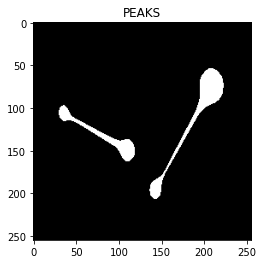

In [14]:
#This will be the markers for the foreground objects (so to lable correctly touching objects with watersheld algorythm)
th, image_b2 = cv2.threshold(image_dist_transform,0.34,1,cv2.THRESH_BINARY)

plt.imshow(image_b2,'gray') 
plt.grid(False)
plt.title('PEAKS')
plt.savefig(f'out_thresholded_{image_to_load}.png')

plt.show()

Now we apply a Dilation to correct the results of the broken parts.

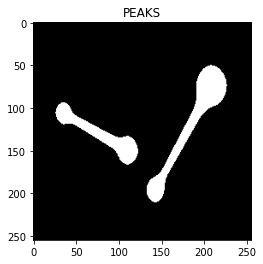

In [15]:

# Closing (done in two step so to have more freedom in using different parameter)
# Dilate a bit the dist image (to classify correctly the TESI00 image)
kernel1 = np.ones((5,5), dtype=np.uint8)
image_b2_dilated = cv2.dilate(image_b2, kernel1)

# Erode im_out in order to divide better the connected region (if we did it right after the dilate the dividing pixel would be not enough)
kernel2 = np.ones((3,3), dtype=np.uint8)
image_b2_dilated = cv2.erode(image_b2_dilated, kernel2)

# Create the CV_8U version of the distance image
# It is needed for findContours()
image_b2_dilated_8u = image_b2_dilated.astype('uint8')

# Find total markers, salva in contours per ogni vettore un'array di vettori 
# contorno per ogni blob
contours, _ = cv2.findContours(image_b2_dilated_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create and initialize the marker image for the watershed algorithm
markers = np.zeros(image_b2.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv2.drawContours(markers, contours, i, (i+1), -1)

# Draw the background marker
markers+=255-image_combined.astype('uint8')
# Perform the watershed algorithm
image_combined_colored= cv2.cvtColor (image_combined, cv2.COLOR_GRAY2RGB)
image_wat = cv2.watershed(image_combined_colored, markers)

image_combined_colored[image_wat == -1] = [0,0,0]  # put the contour in black to mark better the separation.

# # Erode "image_combined_colored" in order to divide better the connected region in TESI50 
kernel2 = np.ones((5,5), dtype=np.uint8)
image_eroded = cv2.erode(image_combined_colored, kernel2)

image_gray = cv2.cvtColor(image_eroded, cv2.COLOR_RGB2GRAY)

plt.imshow(image_gray,'gray') 
plt.grid(False)
plt.title('PEAKS')
plt.savefig(f'out_watershed_plus_mf_{image_to_load}.png')
plt.show()


## In order to proced with the analysis we reintroduce the holes in the right place

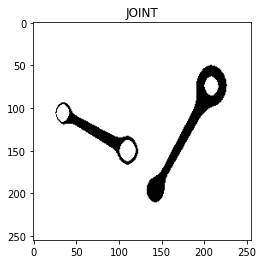

In [16]:
kernel3 = np.ones((5,5), dtype=np.uint8)

image_floodfill_inv = cv2.erode(image_floodfill_inv, kernel3)


image_out = (255-image_gray) + (image_floodfill_inv)

plt.imshow(image_out,'gray') 
plt.grid(False)
plt.title('JOINT')
plt.savefig(f'out_before_labeling_{image_to_load}.png')
plt.show()

# Barycenter

We compute again the baricenters for the convenience of having only the interesting component inside the dictionary.

In [17]:
Barycenter = {}
Barycenter_contours = {}
contours, hierarchy ,Barycenter_contours, Barycenter = Barycenter_computation(image_out,Barycenter_contours,Barycenter)


# CLASSIFICATION OF THE OBJECTS IN THE IMAGE:
Since we removed all possible distractors before, we can only have in the image: ROD_A, ROD_B.

In order to correctly classify them we will look at the hierarchy structure of the contours.

If it has two holes "child" it will be classified as ROD_B.

If it has only one hole "child"  and the barycenter of the child and the object we are analyzing are different, it will be classified as ROD_A.


# Commento hierarchy structure (DA CANCELLARE)

le righe denotano l'obbetto (il contorno),
la colonna 3 ti dice se l'oggetto i-esimo ha un genitore (un contorno che lo ingloba)
la colonna 2 ti dice se l'oggetto i'esimo ha un figlio (un foro al suo interno)


{0: 1, 2: 1, 4: 1}
{1: 'HOLE', 3: 'HOLE', 5: 'HOLE', 0: 'ROD_A', 2: 'ROD_A', 4: 'ROD_A'}


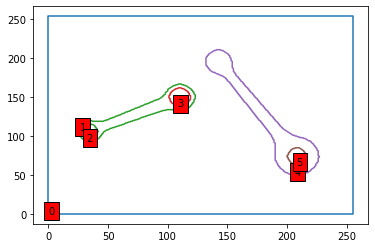

In [18]:
Dict_info_contours = {}
Dict_number_holes = {}  # it stores the number of holes, only of the rods. This is a dictionary made of {key0: value0, key1: value1,...}

for i in range(len(contours)):  # for each contour:    
    if hierarchy[0][i][2] == -1:  # this contour has no child -> it's a hole 
        # we use hierarchy[0] because there is no other hierarchy level. 
        # In our case there are never elements inside the holes.
        
        if hierarchy[0][i][3] != -1: # it has no child but has a parent->
            # it's a hole (element 3 is the parent) for every contour I check if it has a parent, 
            # if it has then I can increment the number of holes of the parent
            Dict_info_contours[i] = 'HOLE'
            # I store the info that its parent has an hole:
            Dict_number_holes[hierarchy[0][i][3]] = Dict_number_holes.get(hierarchy[0][i][3],0) + 1 
            # summing the number of holes in the key of the parent (hierarchy[0][i][3]
            # this is the key of the parent)
            # search the value of the key "hierarchy[0][i][3]" and add 1, 
            # return 0 if you don't find the key in the dictionary
print(Dict_number_holes)     
#[probabilmente farlo in maniera diversa]    
for key,value in Dict_number_holes.items():
    if value == 1:  # it could be the object with a hole which is not a rod.
        Dict_info_contours[key] = 'ROD_A'
                
    if value == 2: #there are 2 holes, then it's a rod of type B
        Dict_info_contours[key] = 'ROD_B'
               
for i in range(len(contours)):
    plt.plot(contours[i][:,0][:,0],contours[i][:,0][:,1])
    plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='red', alpha=1))       
        
print(Dict_info_contours)

# Computation holes' rods diameter

This code computes the diameter based on the max and minimum value of the i,j coordinate of the holes

{1: 1.0, 3: 19.0, 5: 17.0}


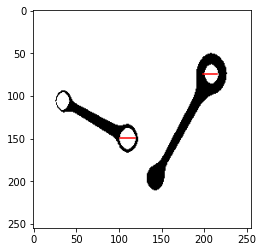

In [19]:
plt.imshow( image_out, cmap='gray', vmin=0, vmax=255);
Dict_hole_diameters = {}
Dict_hole_barycenters = {}
        
for key,value in Dict_info_contours.items():   
     
    if value == 'HOLE': #examinate only holes       
        barycenter = Barycenter[key] # take the barycenter value (+1 to not include the background) 
        min_i = min(contours[key][:,0][:,0]) 
        max_i = max(contours[key][:,0][:,0]) 
        min_j = min(contours[key][:,0][:,1]) 
        max_j = max(contours[key][:,0][:,1])                

        Dict_hole_diameters[key] = ((max_i -min_i -2 ) + (max_j -min_j -2))/2 # np.mean([max_i - min_i -2 , max_j - min_j])
        # The -2 in the previous average is used to avoid counting the initial and final pixel of the diameter
        radius = Dict_hole_diameters[key]/2
        Dict_hole_barycenters[key] = barycenter 
        plt.plot(np.linspace(barycenter[0]-int(radius), barycenter[0]+int(radius)), np.ones(50)*barycenter[1], 'r')  
            
print(Dict_hole_diameters)

# WIDTH AT THE BARYCENTER:
In order to find the width of the rods we need to find the minimum distance between the barycenter and the nearest contours, then we exploit the symmetry of the item we are working with to compute the final value.

How to read "contours[label][:,0][:,0]":

with label you decide with blob (row) you are analyzing, the first [:,0] means that you take all the element in the column 0 (there is only one column in our case),then with the last [:,0] or [:,1] you select if you want to extract the first (i) or the (j).

In [20]:
Dict_width_barycenter = {}

for label in range(1,len(contours)): # start from 1 to avoid the background    
    if Dict_info_contours[label] == 'ROD_A' or Dict_info_contours[label] == 'ROD_B': #taking into analysis only rod A and rod B
        i_coord_contour = contours[label][:,0][:,0] #take the i element of the contour of the "label" rod
        j_coord_contour = contours[label][:,0][:,1] #take the j element of the contour of the "label" rod
        bar = Barycenter[label] #assign to the temporary bar variable the barycenter of the rod
        
        min_dist = 10000 #random value to initialize since we want to find a minimum
        for i in range(len(i_coord_contour)):
            dist_bar = ( (bar[0] - i_coord_contour[i])**2 + (bar[1] - j_coord_contour[i])**2 ) ** (1/2) # square root of the sum of the distance find the minimum distance between the barycenter and the contour
            if dist_bar < min_dist: #find the min distance to the contour
                min_dist = dist_bar #assign the minimum distance
        Dict_width_barycenter[label] = min_dist*2 #finally, just mult by 2 to have the width because of the symmetry of the rod
 

# ORIENTATION, LENGTH, WIDTH
I can use a function which computes all needed: minAreaRect.

Note that the angle that the function will return a value $\in [0, \pi]$


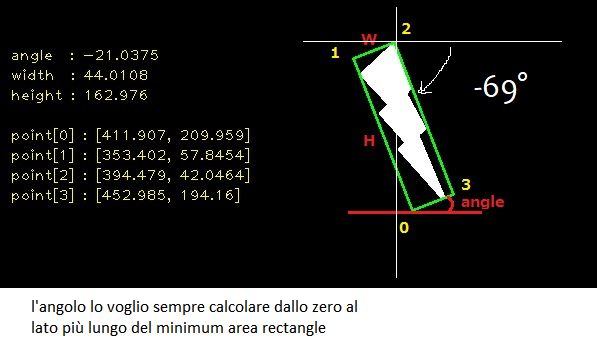

In [21]:
Dict_orientation_rod = {}
Dict_length_rod = {}
Dict_width_rod = {}
for key,value in Dict_info_contours.items(): #I must do it only for rods:
    if value == 'ROD_A' or value == 'ROD_B':
        
        rect = cv2.minAreaRect(contours[key])
        orientation = rect[2]
        if rect[1][0] == max(rect[1][0],rect[1][1]): #compare the two sides of the rectangle, the longer one is the length
            length = rect[1][0]
            width = rect[1][1]
            Dict_orientation_rod[key] = abs(orientation)
            
        else:
            length = rect[1][1]
            width = rect[1][0]
            Dict_orientation_rod[key] = -1*(90+orientation) # see picture above
        
        #store informations:
        Dict_length_rod[key] = length
        Dict_width_rod[key] = width

# ALL THE RESULTS:
where ROD_A is the rod with one hole.

hole diameters:          {1: 1.0, 3: 19.0, 5: 17.0}
hole barycenters:        {1: [27, 109], 3: [110, 149], 5: [207, 74]}
width at the barycenter: {2: 10.770329614269007, 4: 8.94427190999916}
orientation in degree:   {0: -180.0, 2: 32.574058532714844, 4: -115.11483573913574}
length:                  {0: 255.0, 2: 111.44657135009766, 4: 175.9136962890625}
width max rods:          {0: 254.0, 2: 31.507474899291992, 4: 38.79325485229492}
object classification:   {1: 'HOLE', 3: 'HOLE', 5: 'HOLE', 0: 'ROD_A', 2: 'ROD_A', 4: 'ROD_A'}


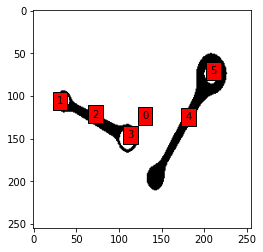

In [22]:
print('hole diameters:         ', Dict_hole_diameters)
print('hole barycenters:       ', Dict_hole_barycenters)
print('width at the barycenter:', Dict_width_barycenter)
print('orientation in degree:  ', Dict_orientation_rod)
print('length:                 ', Dict_length_rod)
print('width max rods:         ', Dict_width_rod) 
print('object classification:  ', Dict_info_contours)

plt.imshow(image_out, cmap='gray', vmin=0, vmax=255);
# see the result on image_denoised, image_out, image

for label,bar in Barycenter.items(): 
    plt.text(bar[0], bar[1], label, bbox=dict(facecolor='red', alpha=1)) 
    plt.scatter(Barycenter[label][0],Barycenter[label][1], color='white')
    plt.savefig(f'out_final_{image_to_load}.png')
